In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from keras.activations import linear

from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.models import Sequential#Import from keras_preprocessing not from keras.preprocessingfrom keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")
import pathlib
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# import seaborn as sn
import math
import os
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from matplotlib import pyplot
from keras.layers import LeakyReLU

Loading Data:
The dataset has been splited into 20% for validation and 80% for training.

In [3]:
batch_size = 32
img_height = 256
img_width = 256
train_data_path = 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/HW3/NWPU-RESISC45/train_ds'
test_data_path = 'E:/OldDrive/Yasin/Fall2021/Neural_Network/Kimia/HW3/NWPU-RESISC45/test_ds'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

Found 24750 files belonging to 45 classes.
Using 19800 files for training.
Found 6750 files belonging to 45 classes.
Using 1350 files for validation.
['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']
0.0 1.0


**Run 1:**
The relu activation function has been used in Con2D layers and MaxPooling layers. 
The optimizer in this run is Adam.

# Run 11: Ensemble Training with Different Nets (Tried to run Resnet 3times each one 20 epochs and then combine three models)

# ResNet 34

In [3]:
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(45)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x




In [4]:
model = ResNet34()
model.build(input_shape=(1, 256, 256, 3))

In [53]:
numberOfModels = 3
for i in range(numberOfModels):
    print('Net', i, 'is being trained...')
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    epochs=20
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=64
    )
    # save the model
    p = ['models1', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))

Net 0 is being trained...
Epoch 1/20
619/619 [==============================] - 45s 69ms/step - loss: 1.7586 - accuracy: 0.4832 - val_loss: 1.4881 - val_accuracy: 0.5504
Epoch 2/20
619/619 [==============================] - 42s 68ms/step - loss: 1.6448 - accuracy: 0.5153 - val_loss: 2.0347 - val_accuracy: 0.5015
Epoch 3/20
619/619 [==============================] - 42s 68ms/step - loss: 1.5481 - accuracy: 0.5379 - val_loss: 15.1806 - val_accuracy: 0.2637
Epoch 4/20
619/619 [==============================] - 42s 68ms/step - loss: 1.4534 - accuracy: 0.5667 - val_loss: 1.3129 - val_accuracy: 0.6259
Epoch 5/20
619/619 [==============================] - 43s 69ms/step - loss: 1.3906 - accuracy: 0.5886 - val_loss: 2.2244 - val_accuracy: 0.4119
Epoch 6/20
619/619 [==============================] - 43s 69ms/step - loss: 1.2932 - accuracy: 0.6135 - val_loss: 1.1299 - val_accuracy: 0.6615
Epoch 7/20
619/619 [==============================] - 43s 69ms/step - loss: 1.1626 - accuracy: 0.6485 - val_l

INFO:tensorflow:Assets written to: models1\model_0.model\assets


INFO:tensorflow:Assets written to: models1\model_0.model\assets


Net 1 is being trained...
Epoch 1/20
619/619 [==============================] - 44s 69ms/step - loss: 0.4248 - accuracy: 0.8751 - val_loss: 8.3457 - val_accuracy: 0.7281
Epoch 2/20
619/619 [==============================] - 43s 69ms/step - loss: 0.3212 - accuracy: 0.9023 - val_loss: 1.1097 - val_accuracy: 0.7681
Epoch 3/20
619/619 [==============================] - 43s 70ms/step - loss: 0.3383 - accuracy: 0.9010 - val_loss: 2.7111 - val_accuracy: 0.4896
Epoch 4/20
619/619 [==============================] - 43s 70ms/step - loss: 0.3589 - accuracy: 0.8970 - val_loss: 1.0648 - val_accuracy: 0.7748
Epoch 5/20
619/619 [==============================] - 43s 69ms/step - loss: 0.2325 - accuracy: 0.9288 - val_loss: 2.5703 - val_accuracy: 0.7541
Epoch 6/20
619/619 [==============================] - 43s 69ms/step - loss: 0.2886 - accuracy: 0.9146 - val_loss: 1.0838 - val_accuracy: 0.7659
Epoch 7/20
619/619 [==============================] - 43s 69ms/step - loss: 0.4102 - accuracy: 0.8909 - val_lo

INFO:tensorflow:Assets written to: models1\model_1.model\assets


INFO:tensorflow:Assets written to: models1\model_1.model\assets


Net 2 is being trained...
Epoch 1/20
619/619 [==============================] - 43s 67ms/step - loss: 0.2184 - accuracy: 0.9402 - val_loss: 1.2160 - val_accuracy: 0.7719
Epoch 2/20
619/619 [==============================] - 41s 67ms/step - loss: 0.2991 - accuracy: 0.9174 - val_loss: 1.2014 - val_accuracy: 0.7474
Epoch 3/20
619/619 [==============================] - 41s 67ms/step - loss: 0.2953 - accuracy: 0.9197 - val_loss: 1.1241 - val_accuracy: 0.7793
Epoch 4/20
619/619 [==============================] - 41s 67ms/step - loss: 0.1907 - accuracy: 0.9463 - val_loss: 1.3184 - val_accuracy: 0.7541
Epoch 5/20
619/619 [==============================] - 42s 67ms/step - loss: 0.1629 - accuracy: 0.9527 - val_loss: 1.3163 - val_accuracy: 0.7756
Epoch 6/20
619/619 [==============================] - 42s 67ms/step - loss: 0.1622 - accuracy: 0.9533 - val_loss: 1.3329 - val_accuracy: 0.7726
Epoch 7/20
619/619 [==============================] - 41s 67ms/step - loss: 0.1643 - accuracy: 0.9538 - val_lo

INFO:tensorflow:Assets written to: models1\model_2.model\assets


INFO:tensorflow:Assets written to: models1\model_2.model\assets


Loading model 1/3
Loading model 2/3
Loading model 3/3
Evaluating ensemble...
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        36
           1       0.58      0.61      0.60        23
           2       0.78      0.86      0.82        29
           3       0.79      0.71      0.75        31
           4       0.77      0.92      0.84        26
           5       0.83      0.83      0.83        30
           6       0.90      1.00      0.95        19
           7       0.75      0.56      0.64        27
           8       0.86      0.89      0.88        28
           9       0.94      1.00      0.97        29
          10       0.71      0.74      0.72        34
          11       0.81      0.91      0.86        33
          12       0.97      0.93      0.95        40
          13       0.97      0.91      0.94        33
          14       0.73      0.73      0.73        33
          15       0.75      0.96      0.84        28
    

<Figure size 432x288 with 0 Axes>

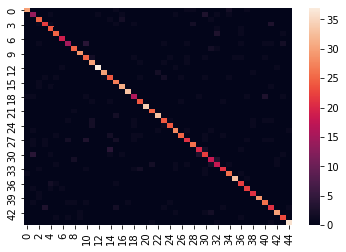

<Figure size 432x288 with 0 Axes>

In [54]:
# construct the path used to collect the models then initialize the
# models list
modelPaths = os.path.sep.join(['models1', '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
    print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []

predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testX = np.concatenate([x for x, y in val_ds], axis=0)
testY = np.concatenate([y for x, y in val_ds], axis=0)
# loop over the models
for model in models:
    # use the current model to make predictions on the testing data,
    # then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=64))

# average the probabilities across all model predictions
predictions = np.average(predictions, axis=0)

#show a classification report
print(classification_report(testY,
                            predictions.argmax(axis=1)))

heatmap(confusion_matrix(testY, predictions.argmax(axis=1)))
plt.figure()

# Run 12: Ensemble Training with Different Nets (Tried to run Resnet and Alexnet 2times each one 20 epochs and then combine two models)

# Alexnet

In [5]:

def AlexNet(img_shape=(256, 256, 3), n_classes=45, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(LeakyReLU(alpha=0.1))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

model = AlexNet()
model.build(input_shape=(256, 256, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 256, 256, 96)      34944     
_________________________________________________________________
batch_normalization_36 (Batc (None, 256, 256, 96)      384       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 96)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 256)     614656    
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 128, 256)     1024      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 256)     0

In [3]:
numberOfModels = 1
for i in range(numberOfModels):
    print('ResNet', i, 'is being trained...')
    model = ResNet34()
    model.build(input_shape=(1, 256, 256, 3))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    epochs=20
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=64
    )
    # save the model
    p = ['models2', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p))

    
for i in range(numberOfModels, 2*numberOfModels):
    print('AlexNet', i - numberOfModels + 1, 'is being trained...')
    model = AlexNet()
    model.build(input_shape=(256, 256, 3))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    epochs=20
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=64
    )
    # save the model
    p = ['models2', 'model_{}.model'.format(i)]
    model.save(os.path.sep.join(p)) 
    

ResNet 0 is being trained...


NameError: name 'ResNet34' is not defined

Loading model 1/2
Loading model 2/2
Evaluating ensemble...
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        36
           1       0.35      0.48      0.41        23
           2       0.40      0.90      0.55        29
           3       0.41      0.52      0.46        31
           4       0.38      0.65      0.48        26
           5       0.76      0.73      0.75        30
           6       0.79      1.00      0.88        19
           7       0.50      0.30      0.37        27
           8       0.83      0.36      0.50        28
           9       0.33      0.86      0.48        29
          10       0.68      0.44      0.54        34
          11       0.71      0.30      0.43        33
          12       0.68      0.95      0.79        40
          13       0.84      0.82      0.83        33
          14       0.64      0.48      0.55        33
          15       0.69      0.89      0.78        28
          16       0.8

<Figure size 432x288 with 0 Axes>

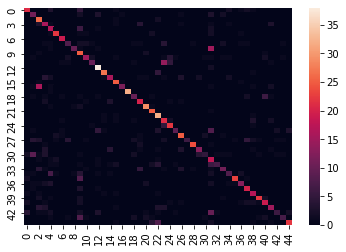

<Figure size 432x288 with 0 Axes>

In [4]:
import glob
from keras.models import load_model
from seaborn import heatmap
# construct the path used to collect the models then initialize the
# models list
modelPaths = os.path.sep.join(['models2', '*.model'])
modelPaths = list(glob.glob(modelPaths))
models = []

# loop over the model paths, loading the model, and adding it to
# the list of models
for (i, modelPath) in enumerate(modelPaths):
    print('Loading model {}/{}'.format(i + 1, len(modelPaths)))
    models.append(load_model(modelPath))

# initialize the list of predictions
print('Evaluating ensemble...')
predictions = []


testX = np.concatenate([x for x, y in val_ds], axis=0)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# loop over the models
for model in models:
    # use the current model to make predictions on the testing data,
    # then store these predictions in the aggregate predictions list
    predictions.append(model.predict(testX, batch_size=64))

# average the probabilities across all model predictions
predictions = np.average(predictions, axis=0)

#show a classification report
print(classification_report(testY,
                            predictions.argmax(axis=1)))

heatmap(confusion_matrix(testY, predictions.argmax(axis=1)))
plt.figure()